In [40]:
import os
import sys

import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import colors
from hydra import initialize, compose
import pickle
from glob import glob
from pprint import pprint
from tqdm import tqdm
from copy import deepcopy

# set paths to various directories based on the machine this code is being executed on
with initialize(version_base=None, config_path='config'):
    config = compose(config_name='config.yaml')  # overrides=['machine=uzay']

array_dir, data_dir, figure_dir, pickle_dir, repo_dir  = config.machine.array_dir, config.machine.data_dir, config.machine.figure_dir, config.machine.pickle_dir, config.machine.repo_dir

# enable use of local modules
if repo_dir not in sys.path:
    sys.path.append(repo_dir)

# set matplotlib style
plt.style.use(f'{repo_dir}/mejiro/mplstyle/science.mplstyle')

from mejiro.lenses.test import SampleStrongLens
from mejiro.plots import diagnostic_plot, plot, plot_util, overplot
from mejiro.analysis import stats
from mejiro.utils import util
from mejiro.helpers import gs, psf

In [41]:
from mejiro.lenses import lens_util
detectable_lenses = lens_util.get_detectable_lenses(config.machine.pipeline_dir, with_subhalos=True)
print(f'Number of detectable lenses: {len(detectable_lenses)}')

  0%|          | 0/975 [00:00<?, ?it/s]

100%|██████████| 975/975 [00:08<00:00, 109.21it/s]

Number of detectable lenses: 975


Narrow down the detectable lenses to a subset that will be most interesting to substructure characterization: massive hosts (so more and larger subhalos) and high SNR.

In [42]:
detectable_lenses = [l for l in detectable_lenses if np.log10(l.main_halo_mass) > 13.3 and l.snr > 25]
print(f'Number of lenses amenable to substructure characterization: {len(detectable_lenses)}')

lens = np.random.choice(detectable_lenses)
print(f'Main halo mass: {np.log10(lens.main_halo_mass):.2f}')

Number of lenses amenable to substructure characterization: 75
Main halo mass: 13.31


In [43]:
# TODO temporary fix
from astropy.cosmology import FlatLambdaCDM
lens.cosmo = FlatLambdaCDM(H0=67.66, Om0=0.30966, Ob0=0.04897)

Optionally, can require that at least one halo over a given mass (here, $10^9 M_\odot$) is within 0.1 arcseconds of an image of the lensed source.

In [44]:
require_alignment = True
subhalo_cone = 5

small_subhalos = lens.generate_cdm_subhalos(log_mlow=6, log_mhigh=7, subhalo_cone=subhalo_cone)
medium_subhalos = lens.generate_cdm_subhalos(log_mlow=7, log_mhigh=8, subhalo_cone=subhalo_cone)

if require_alignment:
    success = False
    i = 0
    while not success:
        large_subhalos = lens.generate_cdm_subhalos(log_mlow=8, log_mhigh=10, subhalo_cone=subhalo_cone)
        success = lens_util.check_halo_image_alignment(lens, large_subhalos, halo_mass=1e9)
        i += 1
    print(f'Generated population after {i} iterations.')
else:
    large_subhalos = lens.generate_cdm_subhalos(log_mlow=8, log_mhigh=10, subhalo_cone=subhalo_cone)

Generated population after 269 iterations.


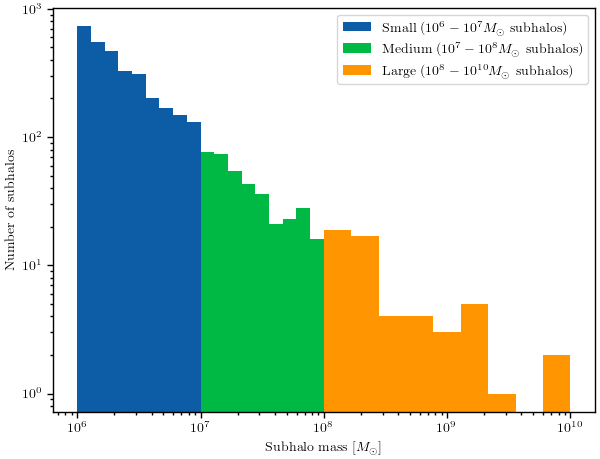

In [45]:
plt.hist([h.mass for h in small_subhalos.halos], label='Small ($10^6-10^7 M_\odot$ subhalos)', bins=np.logspace(6, 7, 10))
plt.hist([h.mass for h in medium_subhalos.halos], label='Medium ($10^7-10^8 M_\odot$ subhalos)', bins=np.logspace(7, 8, 10))
plt.hist([h.mass for h in large_subhalos.halos], label='Large ($10^8-10^{10} M_\odot$ subhalos)', bins=np.logspace(8, 10, 10))
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Subhalo mass [$M_\odot$]')
plt.ylabel('Number of subhalos')
plt.show()

In [46]:
lens_with_small_subhalos = deepcopy(lens)
lens_with_medium_subhalos = deepcopy(lens)
lens_with_large_subhalos = deepcopy(lens)

lens_with_small_subhalos.add_subhalos(small_subhalos)
lens_with_medium_subhalos.add_subhalos(medium_subhalos)
lens_with_large_subhalos.add_subhalos(large_subhalos)

oversample = 3
num_pix = 45
side = 4.95
small_total_kappa = lens_with_small_subhalos.get_total_kappa(num_pix=num_pix * oversample, side=side)
small_subhalo_kappa = lens_with_small_subhalos.get_subhalo_kappa(num_pix=num_pix * oversample, side=side)
medium_total_kappa = lens_with_medium_subhalos.get_total_kappa(num_pix=num_pix * oversample, side=side)
medium_subhalo_kappa = lens_with_medium_subhalos.get_subhalo_kappa(num_pix=num_pix * oversample, side=side)
large_total_kappa = lens_with_large_subhalos.get_total_kappa(num_pix=num_pix * oversample, side=side)
large_subhalo_kappa = lens_with_large_subhalos.get_subhalo_kappa(num_pix=num_pix * oversample, side=side)

In [47]:
einstein_radius = lens.get_einstein_radius()
print(f'Einstein radius: {einstein_radius:.2f} arcsec or about {einstein_radius / 0.11 * oversample:.0f} pixels')

Einstein radius: 1.34 arcsec or about 37 pixels


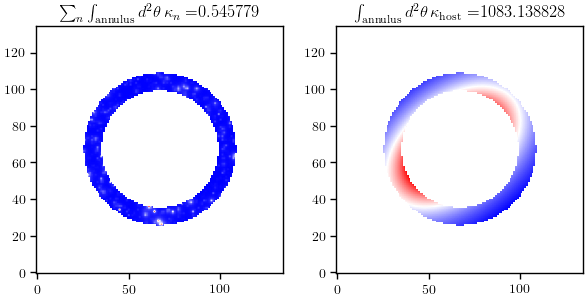

In [48]:
small_f_sub, ax_small = lens_with_small_subhalos.get_f_sub(num_pix=num_pix * oversample, side=side, plot=True)

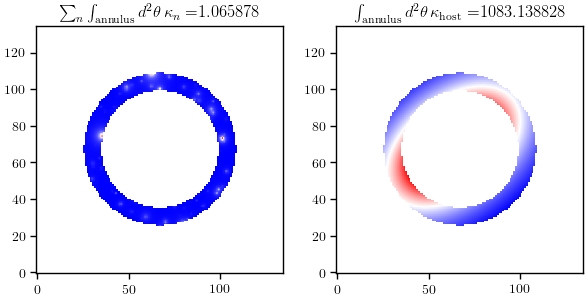

In [49]:
medium_f_sub, ax_medium = lens_with_medium_subhalos.get_f_sub(num_pix=num_pix * oversample, side=side, plot=True)

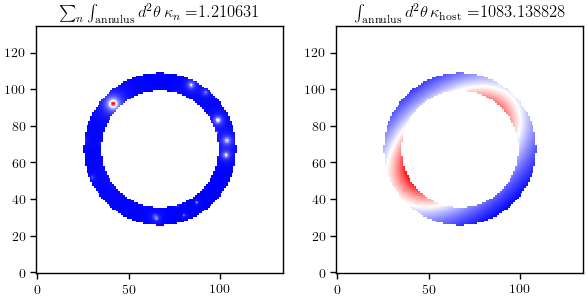

In [50]:
large_f_sub, ax_large = lens_with_large_subhalos.get_f_sub(num_pix=num_pix * oversample, side=side, plot=True)

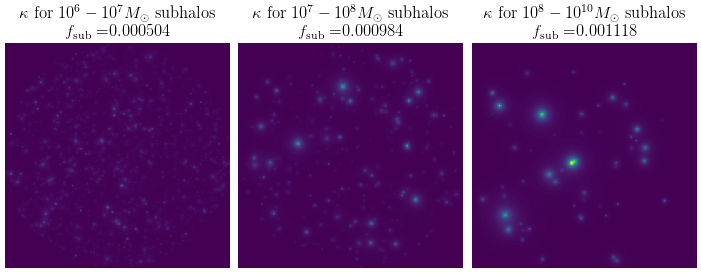

In [51]:
vmax = np.max(large_subhalo_kappa)

_, ax = plt.subplots(1, 3, figsize=(7, 3), constrained_layout=True)
ax[0].imshow(small_subhalo_kappa, vmin=0, vmax=vmax)
ax[1].imshow(medium_subhalo_kappa, vmin=0, vmax=vmax)
ax[2].imshow(large_subhalo_kappa, vmin=0, vmax=vmax)
for a in ax: a.axis('off')
ax[0].set_title(r'$\kappa$' + ' for $10^6-10^7 M_\odot$ subhalos ' + '\n$f_{\mathrm{sub}} = $' + f'{small_f_sub:.6f}')
ax[1].set_title(r'$\kappa$' + ' for $10^7-10^8 M_\odot$ subhalos ' + '\n$f_{\mathrm{sub}} = $' + f'{medium_f_sub:.6f}')
ax[2].set_title(r'$\kappa$' + ' for $10^8-10^{10} M_\odot$ subhalos ' + '\n$f_{\mathrm{sub}} = $' + f'{large_f_sub:.6f}')
plt.show()

Now, combine these subhalo populations so we have three populations with different lower-end mass cutoffs:
1. $10^6-10^{10} M_\odot$, like CDM
2. $10^7-10^{10} M_\odot$, like WDM with less dramatic lower-end mass cutoff
3. $10^8-10^{10} M_\odot$, like WDM with more dramatic lower-end mass cutoff

In [52]:
lens_1 = deepcopy(lens)
lens_2 = deepcopy(lens)
lens_3 = deepcopy(lens)

lens_1_subhalos = deepcopy(large_subhalos).join(deepcopy(medium_subhalos)).join(deepcopy(small_subhalos))
lens_2_subhalos = deepcopy(large_subhalos).join(deepcopy(medium_subhalos))
lens_3_subhalos = deepcopy(large_subhalos)

lens_1.add_subhalos(lens_1_subhalos)
lens_2.add_subhalos(lens_2_subhalos)
lens_3.add_subhalos(lens_3_subhalos)

lens_1_total_kappa = lens_1.get_total_kappa(num_pix=num_pix * oversample, side=side)
lens_1_subhalo_kappa = lens_1.get_subhalo_kappa(num_pix=num_pix * oversample, side=side)
lens_2_total_kappa = lens_2.get_total_kappa(num_pix=num_pix * oversample, side=side)
lens_2_subhalo_kappa = lens_2.get_subhalo_kappa(num_pix=num_pix * oversample, side=side)
lens_3_total_kappa = lens_3.get_total_kappa(num_pix=num_pix * oversample, side=side)
lens_3_subhalo_kappa = lens_3.get_subhalo_kappa(num_pix=num_pix * oversample, side=side)

lens_1_f_sub, _ = lens_1.get_f_sub(num_pix=num_pix * oversample, side=side, plot=False)
lens_2_f_sub, _ = lens_2.get_f_sub(num_pix=num_pix * oversample, side=side, plot=False)
lens_3_f_sub, _ = lens_3.get_f_sub(num_pix=num_pix * oversample, side=side, plot=False)

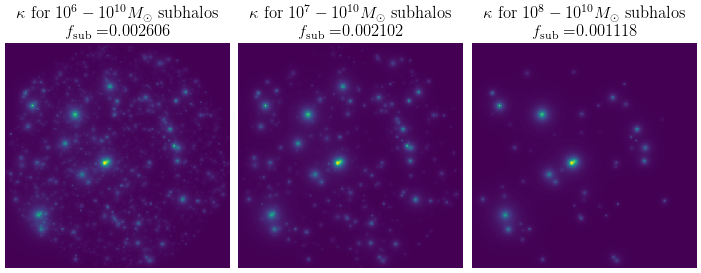

In [53]:
vmax = np.max(lens_3_subhalo_kappa)

_, ax = plt.subplots(1, 3, figsize=(7, 3), constrained_layout=True)
ax[0].imshow(lens_1_subhalo_kappa, vmin=0, vmax=vmax)
ax[1].imshow(lens_2_subhalo_kappa, vmin=0, vmax=vmax)
ax[2].imshow(lens_3_subhalo_kappa, vmin=0, vmax=vmax)
for a in ax: a.axis('off')
ax[0].set_title(r'$\kappa$' + ' for $10^6-10^{10} M_\odot$ subhalos ' + '\n$f_{\mathrm{sub}} = $' + f'{lens_1_f_sub:.6f}')
ax[1].set_title(r'$\kappa$' + ' for $10^7-10^{10} M_\odot$ subhalos ' + '\n$f_{\mathrm{sub}} = $' + f'{lens_2_f_sub:.6f}')
ax[2].set_title(r'$\kappa$' + ' for $10^8-10^{10} M_\odot$ subhalos ' + '\n$f_{\mathrm{sub}} = $' + f'{lens_3_f_sub:.6f}')
plt.show()

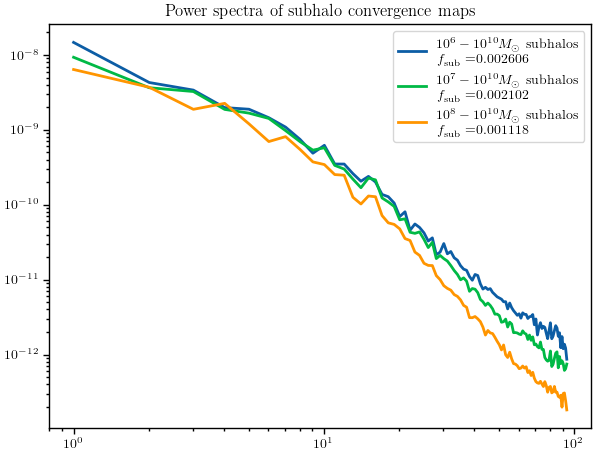

In [54]:
from lenstronomy.Util.correlation import power_spectrum_1d

lens_1_kappa_power_spectrum, k1 = power_spectrum_1d(lens_1_subhalo_kappa)
lens_2_kappa_power_spectrum, k2 = power_spectrum_1d(lens_2_subhalo_kappa)
lens_3_kappa_power_spectrum, k3 = power_spectrum_1d(lens_3_subhalo_kappa)

plt.loglog(k1, lens_1_kappa_power_spectrum, label=r'$10^6-10^{10} M_\odot$ subhalos ' + '\n$f_{\mathrm{sub}} = $' + f'{lens_1_f_sub:.6f}')
plt.loglog(k2, lens_2_kappa_power_spectrum, label=r'$10^7-10^{10} M_\odot$ subhalos ' + '\n$f_{\mathrm{sub}} = $' + f'{lens_2_f_sub:.6f}')
plt.loglog(k3, lens_3_kappa_power_spectrum, label=r'$10^8-10^{10} M_\odot$ subhalos ' + '\n$f_{\mathrm{sub}} = $' + f'{lens_3_f_sub:.6f}')
plt.legend()
plt.title('Power spectra of subhalo convergence maps')
plt.show()

In [55]:
lens_model = lens.get_array(num_pix=num_pix * oversample, side=side, band='F129')
lens_1_model = lens_1.get_array(num_pix=num_pix * oversample, side=side, band='F129')
lens_2_model = lens_2.get_array(num_pix=num_pix * oversample, side=side, band='F129')
lens_3_model = lens_3.get_array(num_pix=num_pix * oversample, side=side, band='F129')

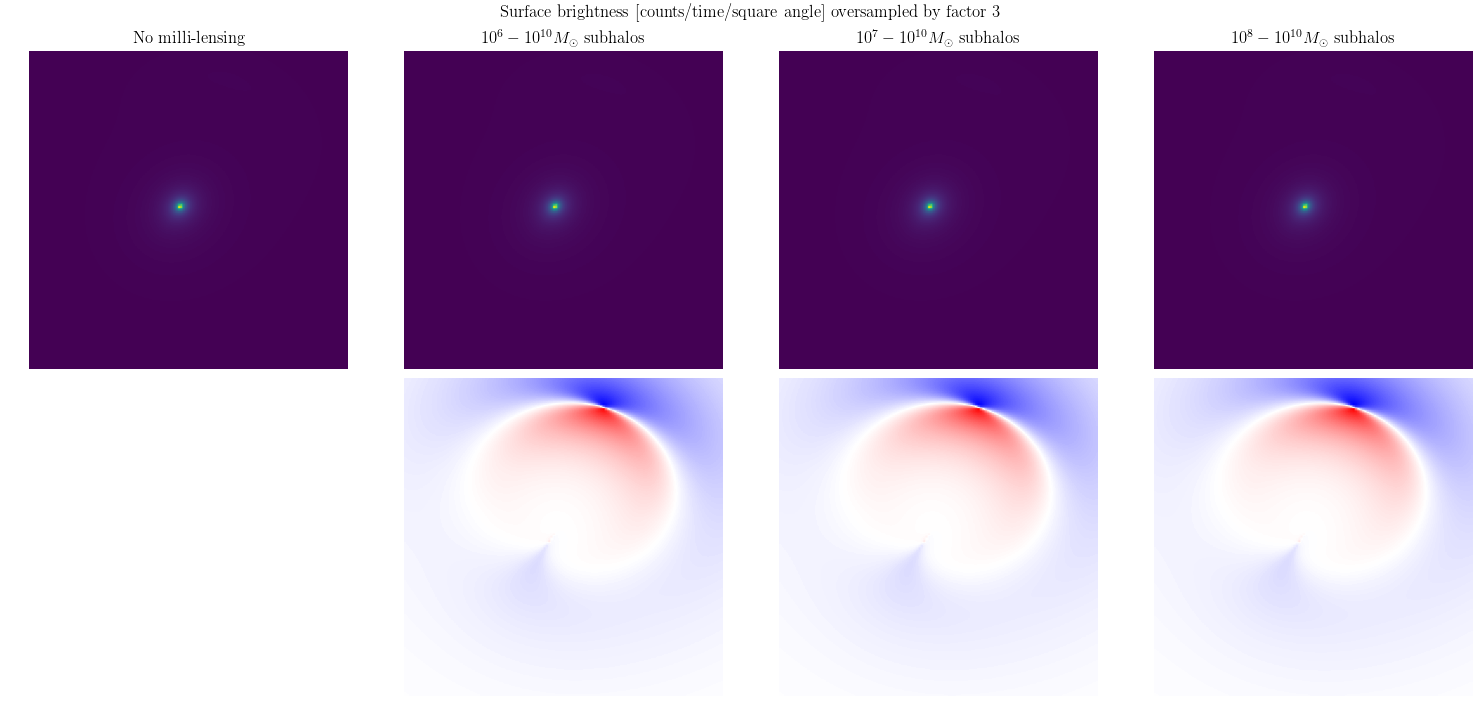

In [56]:
residuals = [lens_1_model - lens_model, lens_2_model - lens_model, lens_3_model - lens_model]
max = np.max(residuals)
min= np.min(residuals)
vmax = np.max([np.abs(min), max])

f, ax = plt.subplots(2, 4, figsize=(15, 7), constrained_layout=True)
ax[0][0].imshow(lens_model)
ax[0][1].imshow(lens_1_model)
ax[0][2].imshow(lens_2_model)
ax[0][3].imshow(lens_3_model)
ax[1][1].imshow(lens_1_model - lens_model, cmap='bwr', vmin=-vmax, vmax=vmax)
ax[1][2].imshow(lens_2_model - lens_model, cmap='bwr', vmin=-vmax, vmax=vmax)
ax[1][3].imshow(lens_3_model - lens_model, cmap='bwr', vmin=-vmax, vmax=vmax)
for a in ax: 
    for b in a: b.axis('off')
ax[0][0].set_title('No milli-lensing')
ax[0][1].set_title(r'$10^6-10^{10} M_\odot$ subhalos')
ax[0][2].set_title(r'$10^7-10^{10} M_\odot$ subhalos')
ax[0][3].set_title(r'$10^8-10^{10} M_\odot$ subhalos')
plt.suptitle(f'Surface brightness [counts/time/square angle] oversampled by factor {oversample}')
plt.show()

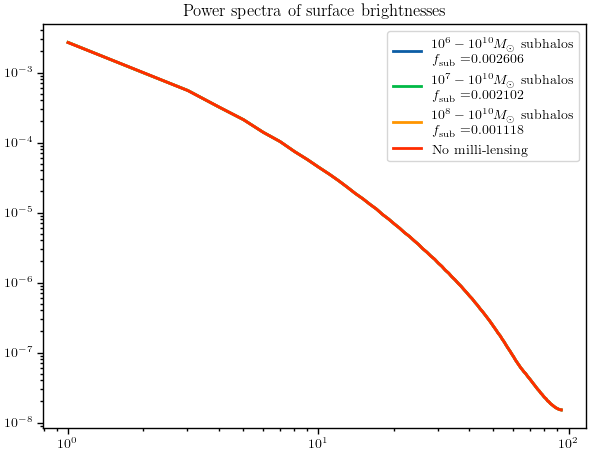

In [57]:
lens_1_model_power_spectrum, k1 = power_spectrum_1d(lens_1_model)
lens_2_model_power_spectrum, k2 = power_spectrum_1d(lens_2_model)
lens_3_model_power_spectrum, k3 = power_spectrum_1d(lens_3_model)
lens_model_power_spectrum, k = power_spectrum_1d(lens_model)

plt.loglog(k1, lens_1_model_power_spectrum, label=r'$10^6-10^{10} M_\odot$ subhalos ' + '\n$f_{\mathrm{sub}} = $' + f'{lens_1_f_sub:.6f}')
plt.loglog(k2, lens_2_model_power_spectrum, label=r'$10^7-10^{10} M_\odot$ subhalos ' + '\n$f_{\mathrm{sub}} = $' + f'{lens_2_f_sub:.6f}')
plt.loglog(k3, lens_3_model_power_spectrum, label=r'$10^8-10^{10} M_\odot$ subhalos ' + '\n$f_{\mathrm{sub}} = $' + f'{lens_3_f_sub:.6f}')
plt.loglog(k, lens_model_power_spectrum, label='No milli-lensing')
plt.legend()
plt.title('Power spectra of surface brightnesses')
plt.show()

We can't distinguish any differences at this scale, so consider residuals: power of image with subhalos minus power of image without subhalos.

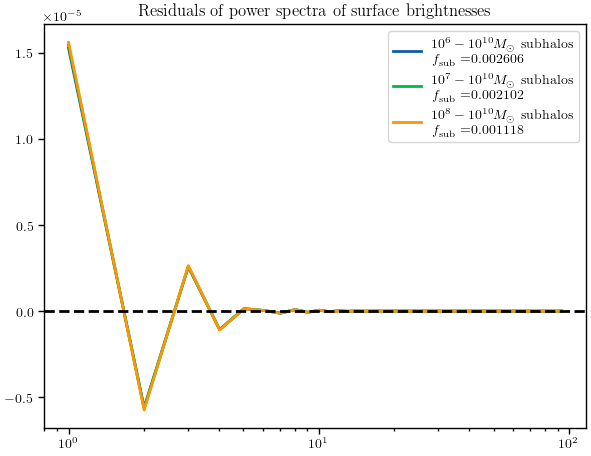

In [58]:
plt.plot(k, lens_1_model_power_spectrum - lens_model_power_spectrum, label=r'$10^6-10^{10} M_\odot$ subhalos ' + '\n$f_{\mathrm{sub}} = $' + f'{lens_1_f_sub:.6f}')
plt.plot(k, lens_2_model_power_spectrum - lens_model_power_spectrum, label=r'$10^7-10^{10} M_\odot$ subhalos ' + '\n$f_{\mathrm{sub}} = $' + f'{lens_2_f_sub:.6f}')
plt.plot(k, lens_3_model_power_spectrum - lens_model_power_spectrum, label=r'$10^8-10^{10} M_\odot$ subhalos ' + '\n$f_{\mathrm{sub}} = $' + f'{lens_3_f_sub:.6f}')
plt.axhline(0, color='black', linestyle='--')
plt.xscale('log')
plt.legend()
plt.title('Residuals of power spectra of surface brightnesses')
plt.show()

Convert surface brightness to counts using GalSim

In [59]:
from galsim import InterpolatedImage, Image

band = 'F129'
detector = 1
detector_position = (2048, 2048)

# no subhalos
total_flux_cps_no_subhalos = lens.get_total_flux_cps(band)
interp_no_subhalos = InterpolatedImage(Image(lens_model, xmin=0, ymin=0), scale=0.11 / oversample, flux=total_flux_cps_no_subhalos * 146)

# population 1
total_flux_cps_1 = lens_1.get_total_flux_cps(band)
interp_1 = InterpolatedImage(Image(lens_1_model, xmin=0, ymin=0), scale=0.11 / oversample, flux=total_flux_cps_1 * 146)

# population 2
total_flux_cps_2 = lens_2.get_total_flux_cps(band)
interp_2 = InterpolatedImage(Image(lens_2_model, xmin=0, ymin=0), scale=0.11 / oversample, flux=total_flux_cps_2 * 146)

# population 3
total_flux_cps_3 = lens_3.get_total_flux_cps(band)
interp_3 = InterpolatedImage(Image(lens_3_model, xmin=0, ymin=0), scale=0.11 / oversample, flux=total_flux_cps_3 * 146)

# get PSF
psf_kernel = psf.get_webbpsf_psf(band, detector, detector_position, oversample=oversample, check_cache=True, suppress_output=False)

# convolve each
image_no_subhalos = gs.convolve(interp_no_subhalos, psf_kernel, num_pix).array
image_1 = gs.convolve(interp_1, psf_kernel, num_pix).array
image_2 = gs.convolve(interp_2, psf_kernel, num_pix).array
image_3 = gs.convolve(interp_3, psf_kernel, num_pix).array

# convert from counts/sec to counts
image_no_subhalos *= 146
image_1 *= 146
image_2 *= 146
image_3 *= 146

Loading cached PSF: /home/btwedig/mejiro/mejiro/data/cached_psfs/F129_1_2048_2048_3.pkl


I'm not adding any sky background, Poisson noise, or detector effects. Only convolving with PSF and converting from surface brightness to counts/pixel

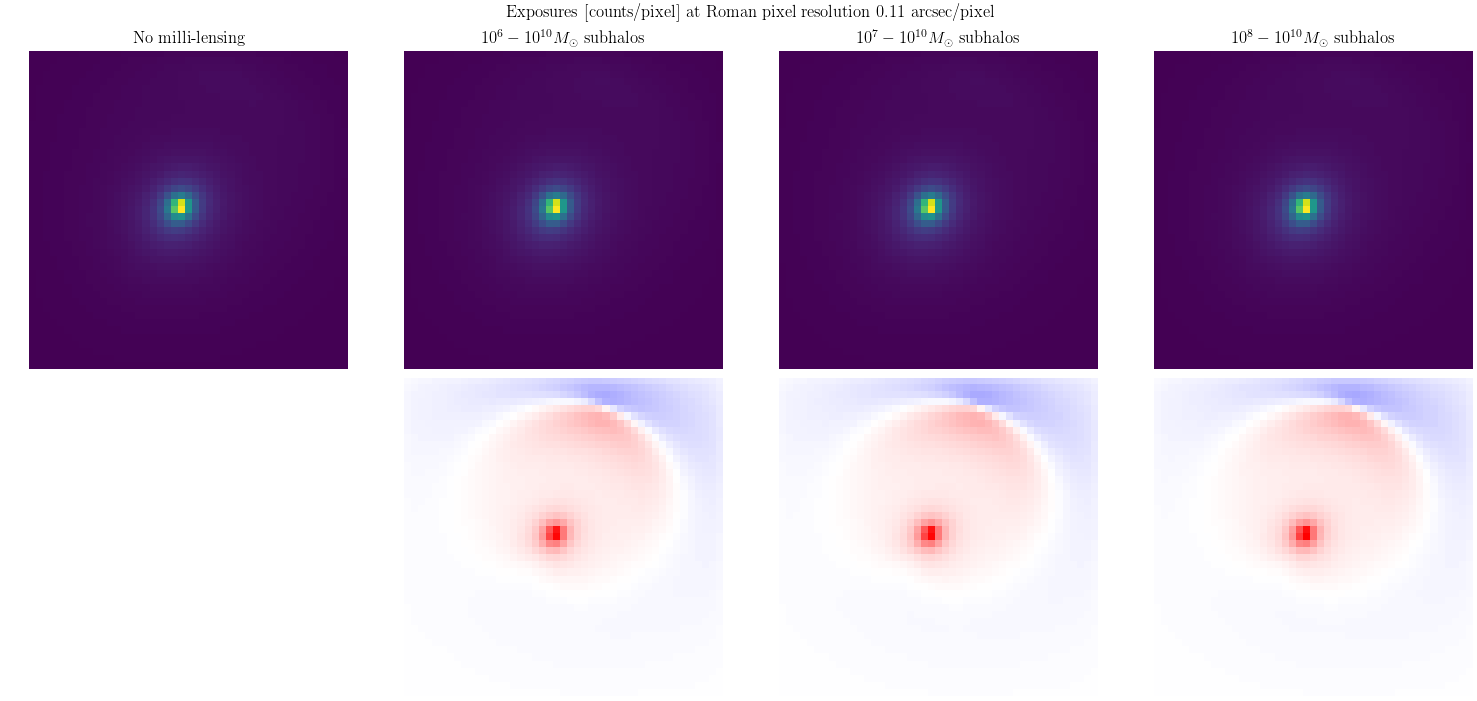

In [60]:
residuals = [image_1 - image_no_subhalos, image_2 - image_no_subhalos, image_3 - image_no_subhalos]
max = np.max(residuals)
min= np.min(residuals)
vmax = np.max([np.abs(min), max])

titles = ['No milli-lensing', r'$10^6-10^{10} M_\odot$ subhalos', r'$10^7-10^{10} M_\odot$ subhalos', r'$10^8-10^{10} M_\odot$ subhalos']

f, ax = plt.subplots(2, 4, figsize=(15, 7), constrained_layout=True)
ax[0][0].imshow(image_no_subhalos)
ax[0][1].imshow(image_1)
ax[0][2].imshow(image_2)
ax[0][3].imshow(image_3)
ax[1][1].imshow(image_1 - image_no_subhalos, cmap='bwr', vmin=-vmax, vmax=vmax)
ax[1][2].imshow(image_2 - image_no_subhalos, cmap='bwr', vmin=-vmax, vmax=vmax)
ax[1][3].imshow(image_3 - image_no_subhalos, cmap='bwr', vmin=-vmax, vmax=vmax)
for a in ax: 
    for b in a: b.axis('off')
for i in range(4):
    ax[0][i].set_title(titles[i])
plt.suptitle(f'Exposures [counts/pixel] at Roman pixel resolution 0.11 arcsec/pixel')
plt.show()

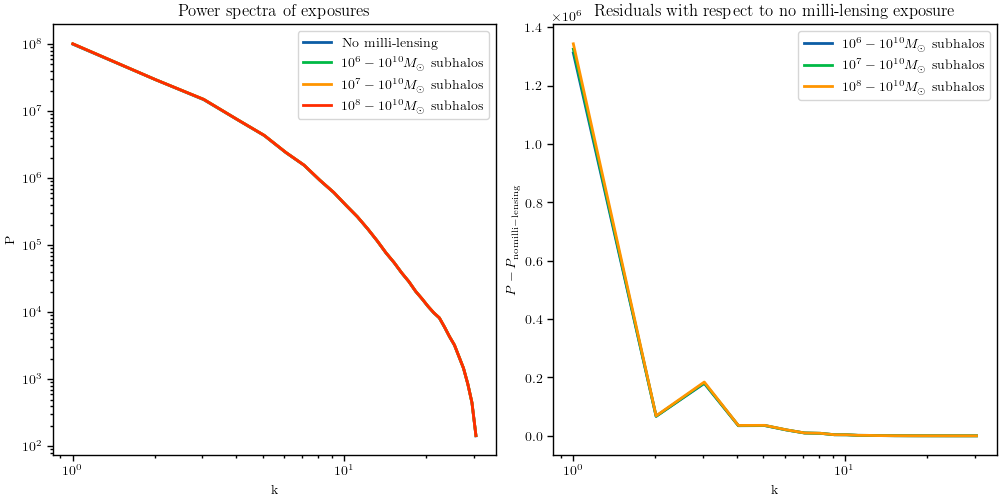

In [61]:
image_no_subhalos_power_spectrum, r = power_spectrum_1d(image_no_subhalos)
image_1_power_spectrum, r = power_spectrum_1d(image_1)
image_2_power_spectrum, r = power_spectrum_1d(image_2)
image_3_power_spectrum, r = power_spectrum_1d(image_3)

f, ax = plt.subplots(1, 2, figsize=(10, 5), constrained_layout=True)
ax[0].loglog(r, image_no_subhalos_power_spectrum, label='No milli-lensing')
ax[0].loglog(r, image_1_power_spectrum, label=r'$10^6-10^{10} M_\odot$ subhalos')
ax[0].loglog(r, image_2_power_spectrum, label=r'$10^7-10^{10} M_\odot$ subhalos')
ax[0].loglog(r, image_3_power_spectrum, label=r'$10^8-10^{10} M_\odot$ subhalos')
ax[0].legend()
ax[0].set_title('Power spectra of exposures')
ax[0].set_xlabel('k')
ax[0].set_ylabel('P')
ax[1].plot(r, image_1_power_spectrum - image_no_subhalos_power_spectrum, label=r'$10^6-10^{10} M_\odot$ subhalos')
ax[1].plot(r, image_2_power_spectrum - image_no_subhalos_power_spectrum, label=r'$10^7-10^{10} M_\odot$ subhalos')
ax[1].plot(r, image_3_power_spectrum - image_no_subhalos_power_spectrum, label=r'$10^8-10^{10} M_\odot$ subhalos')
ax[1].legend()
ax[1].set_xscale('log')
ax[1].set_title('Residuals with respect to no milli-lensing exposure')
ax[1].set_xlabel('k')
ax[1].set_ylabel(r'$P - P_{\mathrm{no milli-lensing}}$')
plt.show()

I'm choosing F129 as the "nominal" band because 1. many other papers also make this choice to represent Roman's HLWAS and 2. the galaxies that form detectable lenses tend to be brightest in this band.

In [62]:
band = 'F129'
detectors = [4, 1, 9, 17]
detector_positions = [(4, 4092), (2048, 2048), (4, 4), (4092, 4092)]

lens_no_subhalos_across_detectors = []
lens_1_across_detectors = []
lens_2_across_detectors = []
lens_3_across_detectors = []

for detector, detector_position in zip(detectors, detector_positions):
    # no subhalos
    total_flux_cps_no_subhalos = lens.get_total_flux_cps(band)
    interp_no_subhalos = InterpolatedImage(Image(lens_model, xmin=0, ymin=0), scale=0.11 / oversample, flux=total_flux_cps_no_subhalos * 146)

    # population 1
    total_flux_cps_1 = lens_1.get_total_flux_cps(band)
    interp_1 = InterpolatedImage(Image(lens_1_model, xmin=0, ymin=0), scale=0.11 / oversample, flux=total_flux_cps_1 * 146)

    # population 2
    total_flux_cps_2 = lens_2.get_total_flux_cps(band)
    interp_2 = InterpolatedImage(Image(lens_2_model, xmin=0, ymin=0), scale=0.11 / oversample, flux=total_flux_cps_2 * 146)

    # population 3
    total_flux_cps_3 = lens_3.get_total_flux_cps(band)
    interp_3 = InterpolatedImage(Image(lens_3_model, xmin=0, ymin=0), scale=0.11 / oversample, flux=total_flux_cps_3 * 146)

    # get PSF
    psf_kernel = psf.get_webbpsf_psf(band, detector, detector_position, oversample=oversample, check_cache=True, suppress_output=False)

    # convolve each
    image_no_subhalos = gs.convolve(interp_no_subhalos, psf_kernel, num_pix).array
    image_1 = gs.convolve(interp_1, psf_kernel, num_pix).array
    image_2 = gs.convolve(interp_2, psf_kernel, num_pix).array
    image_3 = gs.convolve(interp_3, psf_kernel, num_pix).array

    # convert from counts/sec to counts
    image_no_subhalos *= 146
    image_1 *= 146
    image_2 *= 146
    image_3 *= 146

    lens_no_subhalos_across_detectors.append(image_no_subhalos)
    lens_1_across_detectors.append(image_1)
    lens_2_across_detectors.append(image_2)
    lens_3_across_detectors.append(image_3)

Loading cached PSF: /home/btwedig/mejiro/mejiro/data/cached_psfs/F129_4_4_4092_3.pkl
Loading cached PSF: /home/btwedig/mejiro/mejiro/data/cached_psfs/F129_1_2048_2048_3.pkl
Loading cached PSF: /home/btwedig/mejiro/mejiro/data/cached_psfs/F129_9_4_4_3.pkl
Loading cached PSF: /home/btwedig/mejiro/mejiro/data/cached_psfs/F129_17_4092_4092_3.pkl


Visually confirm that no weird artifacts are being introduced

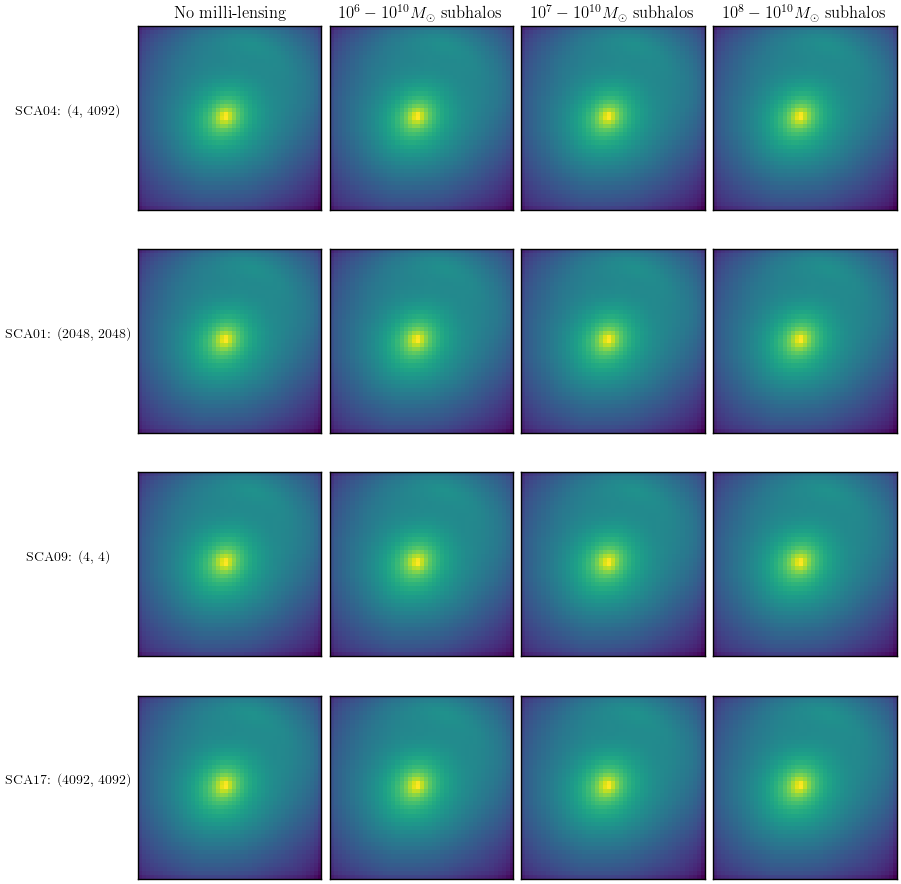

In [63]:
f, ax = plt.subplots(4, 4, figsize=(9,9), constrained_layout=True)
for i in range(4):
    ax[0][i].set_title(titles[i])
    for j in range(4):
        ax[j][i].imshow(np.log10(lens_no_subhalos_across_detectors[j]))
        ax[j][i].imshow(np.log10(lens_1_across_detectors[j]))
        ax[j][i].imshow(np.log10(lens_2_across_detectors[j]))
        ax[j][i].imshow(np.log10(lens_3_across_detectors[j]))

labels = [f'SCA{str(d).zfill(2)}: {dp}' for d, dp in zip(detectors, detector_positions)]
for j in range(4):
    ax[j][0].set_ylabel(labels[j], rotation=0, labelpad=50)

for a in ax.flatten(): 
    a.get_xaxis().set_ticks([])
    a.get_yaxis().set_ticks([])

plt.show()

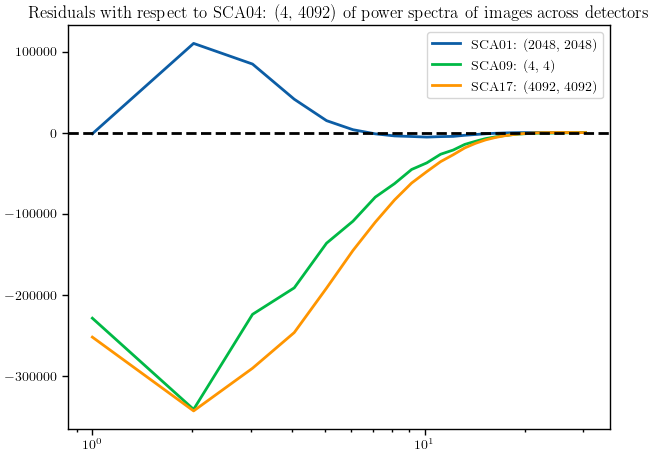

In [64]:
image_nominal_power_spectrum, r = power_spectrum_1d(lens_1_across_detectors[0])
image_pos1_power_spectrum, _ = power_spectrum_1d(lens_1_across_detectors[1])
image_pos2_power_spectrum, _ = power_spectrum_1d(lens_1_across_detectors[2])
image_pos3_power_spectrum, _ = power_spectrum_1d(lens_1_across_detectors[3])

plt.plot(r, image_pos1_power_spectrum - image_nominal_power_spectrum, label=labels[1])
plt.plot(r, image_pos2_power_spectrum - image_nominal_power_spectrum, label=labels[2])
plt.plot(r, image_pos3_power_spectrum - image_nominal_power_spectrum, label=labels[3])
plt.axhline(0, color='black', linestyle='--')
plt.xscale('log')
plt.legend()
plt.title(f'Residuals with respect to {labels[0]} of power spectra of images across detectors')
plt.show()

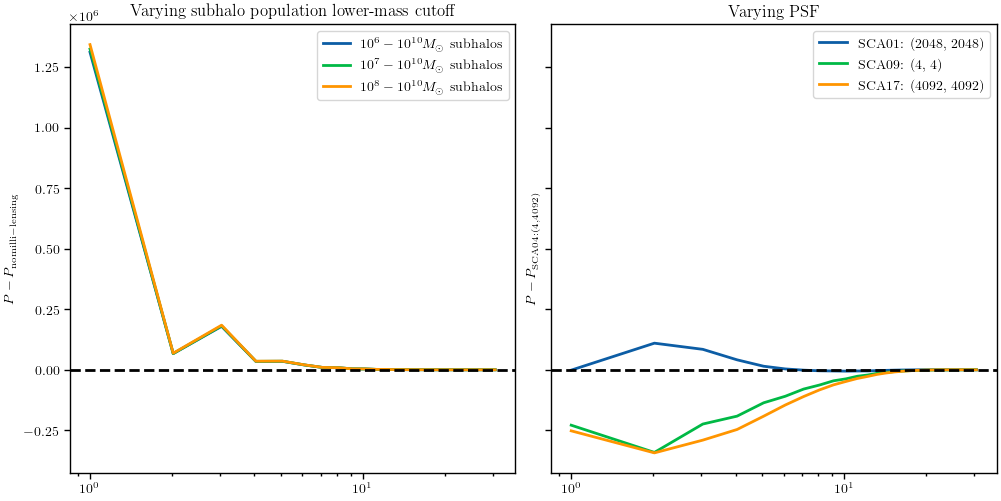

In [65]:
f, ax = plt.subplots(1, 2, figsize=(10, 5), constrained_layout=True, sharey=True)

ax[0].plot(r, image_1_power_spectrum - image_no_subhalos_power_spectrum, label=r'$10^6-10^{10} M_\odot$ subhalos')
ax[0].plot(r, image_2_power_spectrum - image_no_subhalos_power_spectrum, label=r'$10^7-10^{10} M_\odot$ subhalos')
ax[0].plot(r, image_3_power_spectrum - image_no_subhalos_power_spectrum, label=r'$10^8-10^{10} M_\odot$ subhalos')
ax[0].axhline(0, color='black', linestyle='--')
ax[0].legend()
ax[0].set_xscale('log')
ax[0].set_title('Varying subhalo population lower-mass cutoff')
ax[0].set_ylabel(r'$P - P_{\mathrm{no milli-lensing}}$')

ax[1].plot(r, image_pos1_power_spectrum - image_nominal_power_spectrum, label=labels[1])
ax[1].plot(r, image_pos2_power_spectrum - image_nominal_power_spectrum, label=labels[2])
ax[1].plot(r, image_pos3_power_spectrum - image_nominal_power_spectrum, label=labels[3])
ax[1].axhline(0, color='black', linestyle='--')
ax[1].legend()
ax[1].set_xscale('log')
ax[1].set_title('Varying PSF')
ax[1].set_ylabel(r'$P - P_{\mathrm{SCA04: (4, 4092)}}$')
plt.show()

Comparing the two, we now see what we expected: the subhalo signal is comparable to varying the PSF across the focal plane. However, in general, it seems that the differences between subhalo populations are not significant at this scale. Note that the SCA09 and SCA17 positions are at the far edges of the focal plane and therefore represent worst case scenarios.

In [66]:
bands = ['F106', 'F129', 'F158', 'F184']
detector = 1
detector_position = (2048, 2048)

lens_no_subhalos_bands = []
lens_1_bands = []
lens_2_bands = []
lens_3_bands = []

for band in bands:
    # no subhalos
    total_flux_cps_no_subhalos = lens.get_total_flux_cps(band)
    interp_no_subhalos = InterpolatedImage(Image(lens_model, xmin=0, ymin=0), scale=0.11 / oversample, flux=total_flux_cps_no_subhalos * 146)

    # population 1
    total_flux_cps_1 = lens_1.get_total_flux_cps(band)
    interp_1 = InterpolatedImage(Image(lens_1_model, xmin=0, ymin=0), scale=0.11 / oversample, flux=total_flux_cps_1 * 146)

    # population 2
    total_flux_cps_2 = lens_2.get_total_flux_cps(band)
    interp_2 = InterpolatedImage(Image(lens_2_model, xmin=0, ymin=0), scale=0.11 / oversample, flux=total_flux_cps_2 * 146)

    # population 3
    total_flux_cps_3 = lens_3.get_total_flux_cps(band)
    interp_3 = InterpolatedImage(Image(lens_3_model, xmin=0, ymin=0), scale=0.11 / oversample, flux=total_flux_cps_3 * 146)

    # get PSF
    psf_kernel = psf.get_webbpsf_psf(band, detector, detector_position, oversample=oversample, check_cache=True, suppress_output=False)

    # convolve each
    image_no_subhalos = gs.convolve(interp_no_subhalos, psf_kernel, num_pix).array
    image_1 = gs.convolve(interp_1, psf_kernel, num_pix).array
    image_2 = gs.convolve(interp_2, psf_kernel, num_pix).array
    image_3 = gs.convolve(interp_3, psf_kernel, num_pix).array

    # convert from counts/sec to counts
    image_no_subhalos *= 146
    image_1 *= 146
    image_2 *= 146
    image_3 *= 146

    lens_no_subhalos_bands.append(image_no_subhalos)
    lens_1_bands.append(image_1)
    lens_2_bands.append(image_2)
    lens_3_bands.append(image_3)

Loading cached PSF: /home/btwedig/mejiro/mejiro/data/cached_psfs/F106_1_2048_2048_3.pkl
Loading cached PSF: /home/btwedig/mejiro/mejiro/data/cached_psfs/F129_1_2048_2048_3.pkl
Loading cached PSF: /home/btwedig/mejiro/mejiro/data/cached_psfs/F158_1_2048_2048_3.pkl
Loading cached PSF: /home/btwedig/mejiro/mejiro/data/cached_psfs/F184_1_2048_2048_3.pkl


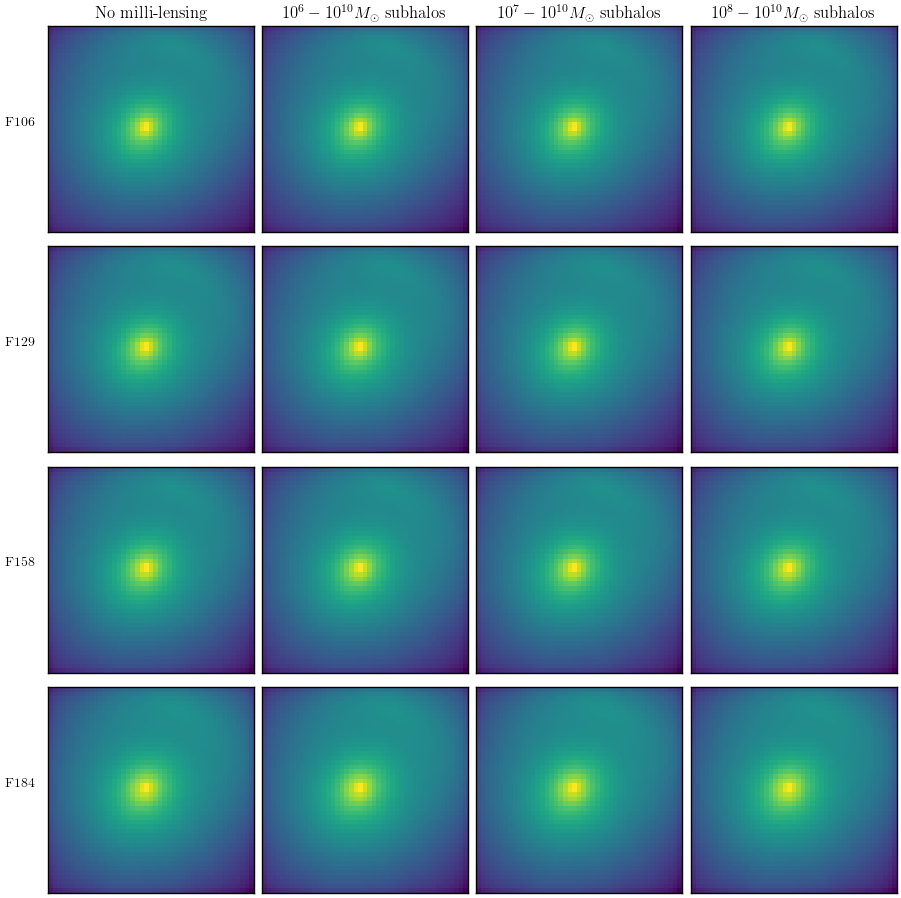

In [67]:
f, ax = plt.subplots(4, 4, figsize=(9,9), constrained_layout=True)
for i in range(4):
    ax[0][i].set_title(titles[i])
    for j in range(4):
        ax[j][i].imshow(np.log10(lens_no_subhalos_bands[j]))
        ax[j][i].imshow(np.log10(lens_1_bands[j]))
        ax[j][i].imshow(np.log10(lens_2_bands[j]))
        ax[j][i].imshow(np.log10(lens_3_bands[j]))

for j in range(4):
    ax[j][0].set_ylabel(bands[j], rotation=0, labelpad=20)

for a in ax.flatten(): 
    a.get_xaxis().set_ticks([])
    a.get_yaxis().set_ticks([])

plt.show()

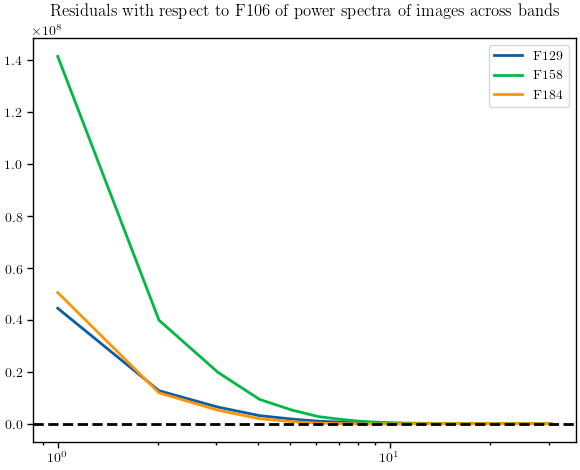

In [68]:
image_F106_power_spectrum, r = power_spectrum_1d(lens_1_bands[0])
image_F129_power_spectrum, _ = power_spectrum_1d(lens_1_bands[1])
image_F158_power_spectrum, _ = power_spectrum_1d(lens_1_bands[2])
image_F184_power_spectrum, _ = power_spectrum_1d(lens_1_bands[3])

plt.plot(r, image_F129_power_spectrum - image_F106_power_spectrum, label=bands[1])
plt.plot(r, image_F158_power_spectrum - image_F106_power_spectrum, label=bands[2])
plt.plot(r, image_F184_power_spectrum - image_F106_power_spectrum, label=bands[3])
plt.axhline(0, color='black', linestyle='--')
plt.xscale('log')
plt.legend()
plt.title(f'Residuals with respect to {bands[0]} of power spectra of images across bands')
plt.show()

Since the variations due to band are so great compared to PSF and subhalo populations, I don't think it's helpful to add this panel. And this was to be expected since the variation in PSF FWHM is significant when going from F106 to F184.

And I have no idea why F158 sticks out so much. I double-checked everything and it all seems fine.

In [69]:
psfs = [psf.get_psf_kernel(band, detector, detector_position, oversample=3) for band in bands]

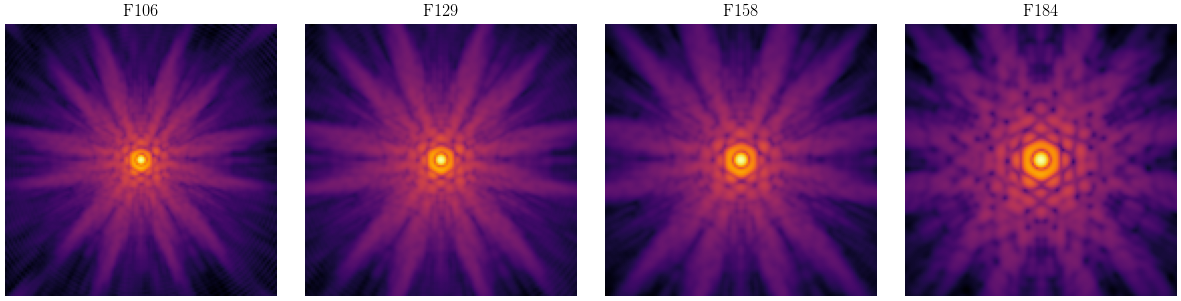

In [70]:
_, ax = plt.subplots(1, 4, figsize=(12, 3), constrained_layout=True)
for i, a in enumerate(ax):
    a.imshow(np.log10(psfs[i]), cmap='inferno')
    a.axis('off')
    a.set_title(bands[i])
plt.show()